## This script compares the fraction of sequences with the RBP motif among the actual vs permuted edit clusters

In [1]:
import os
cwd = os.getcwd()

main_dir = cwd
print(main_dir)

/tscc/lustre/ddn/scratch/q2liang/isSTAMP_publication_scripts/example_analysis_notebooks


In [2]:
import pandas as pd
from glob import glob
import pybedtools
from collections import defaultdict
import subprocess

figures_directory = main_dir + '/figures_actual_vs_shuffule/'

subprocess.run(["mkdir",figures_directory])


CompletedProcess(args=['mkdir', '/tscc/lustre/ddn/scratch/q2liang/isSTAMP_publication_scripts/example_analysis_notebooks/figures_actual_vs_shuffule/'], returncode=1)

### load shuffled stamp peaks

In [3]:
shuffled_dir = main_dir + '/shuffled_confident_clusters/'
shuffled_dir_invivo = main_dir + '/../in_vivo_shuffled_confident_peaks/'
shuffled_peak_with_sequence_filepaths = glob( shuffled_dir + '*/*with_sequence.bed') + glob(shuffled_dir_invivo + '*/*with_sequence.bed')
len(shuffled_peak_with_sequence_filepaths)

120

### Compare permuted fraction for motif

In [4]:
permuted_fractions = pd.read_csv( shuffled_dir + 'RBFOX_cleaned_motif_presence_in_shuffles.tsv', sep='\t', index_col=0)

peak_set_to_motif_presence = defaultdict(lambda:[])
for l, v in permuted_fractions.loc['TGCATG'].items():
    #print(l, v)
    main_category = l.split('_shuffle')[0]
    peak_set_to_motif_presence[main_category].append(v)
    
# load the in vivo experiment data
permuted_fractions_invivo = pd.read_csv( shuffled_dir_invivo + 'RBFOX_cleaned_motif_presence_in_shuffles.tsv', sep='\t', index_col=0)
for l, v in permuted_fractions_invivo.loc['TGCATG'].items():
    #print(l, v)
    main_category = l.split('_shuffle')[0]
    peak_set_to_motif_presence[main_category].append(v)


### Find actual fraction with motif

In [5]:
from pyfaidx import Fasta
import re
fasta = '/tscc/lustre/ddn/scratch/q2liang/reference/hg38.fa'
FA = Fasta(fasta, rebuild=False)
import math

def get_sequence(r): 
    chrom = str(r.chrom)
    start = r.start
    end = r.end
    strand = r.strand
    
    sequence = FA[chrom][start:end].seq
    sequence = sequence.upper()
        
    return sequence

def get_extended_sequence(r): 
    chrom = str(r.chrom)
    
    midpoint = r.start + (int((r.end - r.start)/2))
    start = midpoint - 400
    end = midpoint + 400
    strand = r.strand
    
    sequence = FA[chrom][start:end].seq
    sequence = sequence.upper()
        
    return sequence

complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
def reverse_complement(seq):
    return "".join(complement.get(base, base) for base in reversed(seq))

def reverse(seq):
    return seq[::-1]

def motif_present(sequence, motif, strand):
    if strand == '+':
        return motif in sequence
    elif strand == '-':
        return reverse_complement(motif) in sequence

def motif_distance_from_center(sequence, motif, strand):
    #print(sequence)
    if strand == '+':
        search_term = motif
    elif strand == '-':
        search_term = reverse_complement(motif)
    else:
        search_term = motif
        
    if search_term in sequence:
        closest_position_in_first_half = 1000
        closest_position_in_second_half = 1000
        
        midpoint = math.ceil(len(sequence)/2)
        #print('\tmidpoint is {}'.format(midpoint))
        start_of_second_half = midpoint-len(motif)

        sequence_first_half = sequence[0:midpoint]
        sequence_second_half = sequence[start_of_second_half:]

        #print('\tSplit:', sequence_first_half, sequence_second_half)
        if search_term in sequence_first_half:
            flipped_sequence = reverse(sequence_first_half)
            flipped_search_term = reverse(search_term)
            
            #print('searching for {} in {}'.format(flipped_search_term, flipped_sequence))
            closest_position_in_first_half = - flipped_sequence.index(flipped_search_term) - math.floor(len(motif)/2)
            
        if search_term in sequence_second_half:
            closest_position_in_second_half = sequence_second_half.index(search_term) - math.floor(len(motif)/2)

        #print([closest_position_in_first_half, closest_position_in_second_half])
        if min(abs(closest_position_in_second_half), abs(closest_position_in_first_half)) == abs(closest_position_in_second_half):
            return closest_position_in_second_half
        else:
            return closest_position_in_first_half
    else:
        return None
    
motifs = ['TGCATG']

def add_sequence_presences(r, window_size=70):
    extended_sequence = r['extended_sequence(+)']
    strand = r.strand

    distance_tgcatg = motif_distance_from_center(extended_sequence, 'TGCATG', strand)

    sequence = r['sequence(+)']

    presence_map = {motif: motif_present(sequence, motif, strand) for motif in motifs}
    return presence_map.get(motifs[0]), distance_tgcatg


def calculate_fractions(p_df):
    fractions_dict = {}
    counts_dict = {}
    
    for motif in motifs:
        motif_present_count = p_df[motif].sum()
        motif_present_fraction = motif_present_count/len(p_df)
        fractions_dict[motif] = motif_present_fraction
        counts_dict[motif] = motif_present_count
    
    return fractions_dict, counts_dict

/tscc/nfs/home/q2liang/miniconda3/envs/py3/lib/python3.6/site-packages/pyfaidx/__init__.py:498: RuntimeWarning: Index file /tscc/lustre/ddn/scratch/q2liang/reference/hg38.fa.fai is older than FASTA file /tscc/lustre/ddn/scratch/q2liang/reference/hg38.fa.
  ), RuntimeWarning


In [7]:
peak_filepaths = sorted(glob(main_dir + '/confident_clusters/*_cleaned_confident_clusters.bed')) 

stamp_file_dfs = {}
all_sample = []

for peak_filepath in peak_filepaths:    
    file_id = peak_filepath.split('/')[-1].split('_cleaned_confident')[0]
    if 'TDP43' in file_id:
        continue
    print('\t', file_id)
    all_sample.append(file_id)
    stamp_file_dfs[file_id] = pd.read_csv(peak_filepath, sep='\t', header=None, names = ['chrom', 'start', 'end', 'depth', 'fractions', 'strand', 'region'])

# load the in vivo stamp data
peak_filepaths_invivo = sorted(glob(main_dir + '/../in_vivo_confident_peaks/*.bed')) 
for peak_filepath in peak_filepaths_invivo:    
    file_id = peak_filepath.split('/')[-1].split('.bed')[0]
    print('\t', file_id)
    all_sample.append(file_id)
    stamp_file_dfs[file_id] = pd.read_csv(peak_filepath, sep='\t', header=None, names = ['chrom', 'start', 'end', 'depth', 'fractions', 'strand', 'region'])


	 Enzyme_Only_PFA
	 RBFOX2_INSCRIBE_PFA
	 RBFOX2_ct_APOBEC1_alone
	 RBFOX2_ct_FOX2-APOBEC1
	 RBFOX2_ct_FOX2-APOBEC1_cleaned


In [8]:
from collections import defaultdict

actual_motif_fractions = defaultdict(lambda:{})
dfs_with_motif_info = {}

for label,df in stamp_file_dfs.items():
    print(label)
    print('\t', len(df))
    df['sequence(+)'] = df.apply(get_sequence, axis=1)
    df['extended_sequence(+)'] = df.apply(get_extended_sequence, axis=1)

    df[motifs[0]],df['TGCATG_dist_from_center'] = zip(*df.apply(add_sequence_presences, axis=1))
    
    dfs_with_motif_info[label] = df
    
    for motif in motifs:
        print('Checking {}'.format(motif))
        actual_motif_fractions[label][motif] = len(df[df[motif] == True])/len(df)

Enzyme_Only_PFA
	 1678
Checking TGCATG
RBFOX2_INSCRIBE_PFA
	 2970
Checking TGCATG
RBFOX2_ct_APOBEC1_alone
	 2044
Checking TGCATG
RBFOX2_ct_FOX2-APOBEC1
	 2252
Checking TGCATG
RBFOX2_ct_FOX2-APOBEC1_cleaned
	 1893
Checking TGCATG


### plot the cleaned confident clusters

['RBFOX2_ct_FOX2-APOBEC1_cleaned', 'Enzyme_Only_PFA', 'RBFOX2_INSCRIBE_PFA']
['RBFOX2 in cell STAMP', 'INSCRIBE Enzyme-Only\n(PFA-fixed)', 'RBFOX2 INSCRIBE\n(PFA-fixed)']
for-pub-rbfox2
	 /tscc/lustre/ddn/scratch/q2liang/isSTAMP_publication_scripts/example_analysis_notebooks/figures_actual_vs_shuffule//stamp_peak_tgcatg_motif_permutation-for-pub-rbfox2
Enzyme_Only_PFA 0.2
RBFOX2_INSCRIBE_PFA 0.0
RBFOX2_ct_APOBEC1_alone 0.75
RBFOX2_ct_FOX2-APOBEC1_cleaned 0.0
RBFOX2_ct_FOX2-APOBEC1 0.0


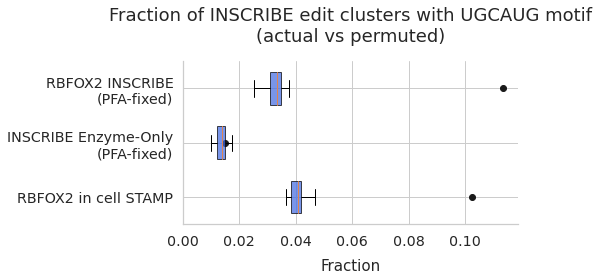

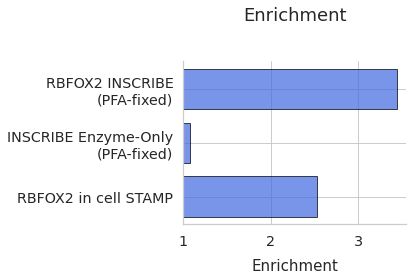

In [9]:
to_plot_together_label = ['RBFOX2_ct_FOX2-APOBEC1_cleaned','Enzyme_Only_PFA','RBFOX2_INSCRIBE_PFA']
print(to_plot_together_label)

label_to_legend_dict = {
'RBFOX2_INSCRIBE_PFA':'RBFOX2 INSCRIBE\n(PFA-fixed)',
'Enzyme_Only_PFA':'INSCRIBE Enzyme-Only\n(PFA-fixed)',
'RBFOX2_ct_FOX2-APOBEC1_cleaned': 'RBFOX2 in cell STAMP'
}

legends = [label_to_legend_dict.get(i) for i in to_plot_together_label]
print(legends)

from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
plt.rcParams['pdf.fonttype'] = 42

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.3)

label_options = [to_plot_together_label]

title_base = 'stamp_peak_tgcatg_motif_permutation-'
title_options = ['for-pub-rbfox2']



for labels_subset, title_suffix in zip(label_options, title_options):

    print(title_suffix)
    
    for l in labels_subset:
        assert(l in peak_set_to_motif_presence.keys())


    # Plot boxplots
    plt.figure(figsize=(6, 3))

    a = plt.boxplot([peak_set_to_motif_presence.get(l) for l in labels_subset]
                    , vert=False, showfliers=False, patch_artist=True,  widths= 0.6,
            boxprops=dict(facecolor='royalblue', color='black',  alpha=0.7))

    range_array= [i+1 for i in range(len(labels_subset))]

    b = plt.scatter([actual_motif_fractions.get(l).get('TGCATG') for l in labels_subset], range_array, color='k')
    plt.xlabel("Fraction", labelpad = 10,  fontsize = 15)
    plt.title("Fraction of INSCRIBE edit clusters with UGCAUG motif\n(actual vs permuted)", pad=20,  fontsize = 18)
    c = plt.yticks(range_array, legends)
    plt.xlim(left=0)


    filename = '{}/{}{}'.format(figures_directory, title_base, title_suffix)
    print('\t', filename)
    # plt.savefig('{}-box-color.png'.format(filename), bbox_inches='tight', dpi = 300)
    # plt.savefig('{}-box-color.svg'.format(filename), bbox_inches='tight', dpi = 300)
    # plt.savefig('{}-box-color.pdf'.format(filename), bbox_inches='tight', dpi = 300)


    # Plot enrichment

    tick_list = legends

    motif_odds_ratios = {}
    for k in peak_set_to_motif_presence.keys():

        permuted_val = np.mean(peak_set_to_motif_presence.get(k))
        actual_val = actual_motif_fractions.get(k).get('TGCATG')
        
        num_exceeding_actual = [v for v in peak_set_to_motif_presence.get(k) if v > actual_val]
        pval = len(num_exceeding_actual)/len(peak_set_to_motif_presence.get(k))
        print(k, pval)
        motif_odds_ratios[k] = actual_val/permuted_val
    
        
    ordered_motif_ors = []
    for o in labels_subset:
        ordered_motif_ors.append(motif_odds_ratios.get(o))

    min_odds_ratio = np.min(ordered_motif_ors)
    max_odds_ratio = np.max(ordered_motif_ors)
    
    plt.figure(figsize=(4, 3))
    plt.barh(tick_list, ordered_motif_ors, color='royalblue', edgecolor = 'black',  alpha=0.7, height = 0.75)
    plt.xlim(1,max_odds_ratio+0.1)
    plt.title("Enrichment\n", pad=20, fontsize = 18)
    plt.xlabel("Enrichment", labelpad = 10, fontsize = 15)

    
    # plt.savefig('{}-enrich-color.png'.format(filename), bbox_inches='tight', dpi = 300)
    # plt.savefig('{}-enrich-color.svg'.format(filename), bbox_inches='tight', dpi = 300)
    # plt.savefig('{}-enrich-color.pdf'.format(filename), bbox_inches='tight', dpi = 300)

In [10]:
motif_odds_ratios

{'Enzyme_Only_PFA': 1.0843338469141546,
 'RBFOX2_INSCRIBE_PFA': 3.4479511888373358,
 'RBFOX2_ct_APOBEC1_alone': 0.8998875140607424,
 'RBFOX2_ct_FOX2-APOBEC1_cleaned': 2.530357858800897,
 'RBFOX2_ct_FOX2-APOBEC1': 2.303850623862465}

In [11]:
import numpy as np
from scipy import stats


for l in labels_subset:
    print(l)
    actual_value = actual_motif_fractions.get(l).get('TGCATG') 
    shuffle_values = peak_set_to_motif_presence.get(l)
    mean = np.mean(shuffle_values)
    std = np.std(shuffle_values)
    zscore = (actual_value - mean) / std 
    print(zscore)


RBFOX2_ct_FOX2-APOBEC1_cleaned
23.084811161868075
Enzyme_Only_PFA
0.5653924006038678
RBFOX2_INSCRIBE_PFA
25.78601344357309
